In [ ]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Metadata Preprocessing
metadata_path = 'train.csv'
metadata_df = pd.read_csv(metadata_path)

# Function to clean and normalize poster filenames
def clean_filename(title):
    # Remove unwanted special characters except for - and '.
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title) 
    return title

# Generate normalized filenames by combining the title and year
metadata_df['Poster_Filename'] = metadata_df['Title'].apply(clean_filename) + '_' + metadata_df['Year'].astype(str) + '.jpg'



In [ ]:
# 2. Poster Preprocessing
poster_folder = '/content/drive/MyDrive/posters'
image_size = (224, 224) # Resize all images to 224x224

# Process and normalize poster images
X_images = []
for filename in metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder, filename) # Construct image path
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB') # Open and convert image to RGB
        img = img.resize(image_size)
        img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        X_images.append(img)
    else:
        print(filename)
        # Replace missing images with random noise
        X_images.append(np.random.normal(0.5, 0.1, (*image_size, 3)))  

X_images = np.array(X_images)  # Convert list to NumPy array

In [ ]:
# 3. Metadata Feature Preprocessing
# Normalize numerical features
numerical_features = ['Runtime(min)', 'Budget']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler() 
X_numeric = scaler.fit_transform(metadata_df[numerical_features].values)

# Encode categorical features
categorical_features = ['Director', 'Country', 'Genre1', 'Genre2', 'Genre3', 'Actor1', 'Actor2', 'Actor3']
encoders = {}  # Dictionary to store encoders for each categorical feature
X_categorical = []
for feature in categorical_features:
    le = LabelEncoder()  # Initialize label encoder
    metadata_df[feature] = le.fit_transform(metadata_df[feature])  # Transform categorical data to numerical
    X_categorical.append(metadata_df[feature].values)   # Store transformed feature
    encoders[feature] = le

# Combine all categorical features into a single array
X_categorical = np.column_stack(X_categorical)

# Target variable (log-transformed BoxOffice values)
Y = np.log1p(metadata_df['BoxOffice'].values)

In [ ]:

# Split data into training and validation sets
X_img_train, X_img_val, X_num_train, X_num_val, X_cat_train, X_cat_val, Y_train, Y_val = train_test_split(
    X_images, X_numeric, X_categorical, Y, test_size=0.2, random_state=42)

In [ ]:
# Model Definition
# Define an EfficientNetB0 model for image feature extraction
image_input = layers.Input(shape=(224, 224, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model weights
x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define an MLP for metadata processing
metadata_input = layers.Input(shape=(X_numeric.shape[1] + X_categorical.shape[1],))
y = layers.Dense(128, activation='relu')(metadata_input)
y = layers.Dense(64, activation='relu')(y)

In [ ]:

# Combine image and metadata features and define the output layer
combined = layers.concatenate([x, y])
output = layers.Dense(1)(combined)

In [ ]:
# Compile the model with Adam optimizer and mean squared error loss
model = models.Model(inputs=[image_input, metadata_input], outputs=output)
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Model Training
# Early stopping callback to prevent overfitting

callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_img_train, np.hstack([X_num_train, X_cat_train])], Y_train,
                    validation_data=([X_img_val, np.hstack([X_num_val, X_cat_val])], Y_val),
                    epochs=100, batch_size=16, callbacks=[callback])


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 59s 498ms/step - loss: 51.6551 - mae: 5.5979 - val_loss: 20.9592 - val_mae: 3.5045
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 19.4965 - mae: 3.4796 - val_loss: 16.2473 - val_mae: 3.0475
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 16.8695 - mae: 3.1826 - val_loss: 14.4568 - val_mae: 2.9195
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 13.9582 - mae: 2.9134 - val_loss: 13.1061 - val_mae: 2.8056
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.7595 - mae: 2.8311 - val_loss: 12.0449 - val_mae: 2.7394
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 10.8073 - mae: 2.6090 - val_loss: 11.0901 - val_mae: 2.6082
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.6312 - mae: 2.4318 - val_loss: 9.0130 - val_mae: 2.3109
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.7830 - mae: 2.3240 - val_loss: 8.4610 - val_mae: 2.2441
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s

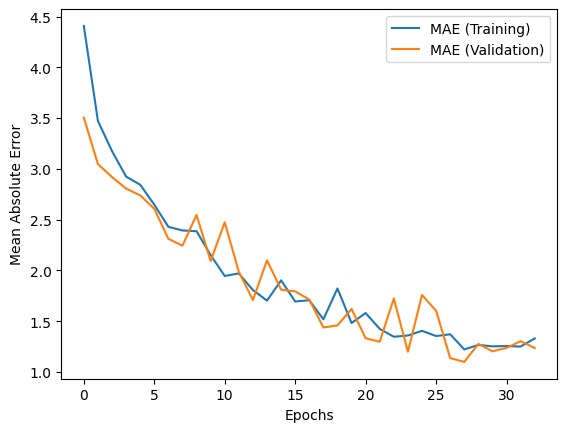

In [ ]:

# Plot training and validation Mean Absolute Error (MAE) over epochs
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
# Test Data Processing
# Load the test metadata
test_metadata_path = 'test.csv'
test_metadata_df = pd.read_csv(test_metadata_path)

# Function to clean and normalize poster filenames
def clean_filename(title):
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title)  # Remove unwanted special characters
    return title


# Generate normalized poster filenames for the test set
test_metadata_df['Poster_Filename'] = test_metadata_df['Title'].apply(clean_filename) + '_' + test_metadata_df['Year'].astype(str) + '.jpg'


In [ ]:
# Process test posters
poster_folder2 = '/content/drive/MyDrive/posters_test'
image_size = (224, 224)
X_test_images = []
for filename in test_metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder2, filename)
    if os.path.exists(img_path):  # If the poster exists, load and preprocess it
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size)
        img = np.array(img) / 255.0   # Normalize pixel values
        X_test_images.append(img)
    else:   # Handle missing posters with noisy images
        print(filename)
        X_test_images.append(np.random.normal(0.5, 0.1, (*image_size, 3))) 

# Convert test images to a NumPy array
X_test_images = np.array(X_test_images)

In [ ]:
# Process numerical features in test data

X_test_numeric = scaler.transform(test_metadata_df[numerical_features].values)

In [ ]:
# Encode categorical features in test data using the same encoders
X_test_categorical = []
for feature in categorical_features:
    
    encoder = encoders[feature]
    test_labels = test_metadata_df[feature]

    # Assign unknown labels if not seen during training
    test_labels = test_labels.apply(lambda x: x if x in encoder.classes_ else 'Unknown')

    # 'Unknown' sınıfını ekle
    if 'Unknown' not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, 'Unknown')

    # Transform test data labels
    X_test_categorical.append(encoder.transform(test_labels))
X_test_categorical = np.column_stack(X_test_categorical)

In [ ]:

# Get actual BoxOffice values for test data
Y_test_actual = np.log1p(test_metadata_df['BoxOffice'].values)

In [ ]:
# Model Evaluation
# Make predictions on test data
Y_test_pred = model.predict([X_test_images, np.hstack([X_test_numeric, X_test_categorical])])

# Evaluate model performance on test data

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test_actual, Y_test_pred)
mae = mean_absolute_error(Y_test_actual, Y_test_pred)

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Test Set MSE: 5.9761
Test Set MAE: 1.8212
